# 出租车数据处理

下面我们介绍如何使用TransBigData包，调用其中的函数实现对出租车GPS数据的快速处理。  
首先我们引入TransBigData包，并读取数据:

In [1]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd
#读取数据    
data = pd.read_csv('TaxiData-Sample.csv',header = None) 
data.columns = ['VehicleNum','Time','Lng','Lat','OpenStatus','Speed']    
data

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed
0,34745,20:27:43,113.806847,22.623249,1,27
1,34745,20:24:07,113.809898,22.627399,0,0
2,34745,20:24:27,113.809898,22.627399,0,0
3,34745,20:22:07,113.811348,22.628067,0,0
4,34745,20:10:06,113.819885,22.647800,0,54
...,...,...,...,...,...,...
544994,28265,21:35:13,114.321503,22.709499,0,18
544995,28265,09:08:02,114.322701,22.681700,0,0
544996,28265,09:14:31,114.336700,22.690100,0,0
544997,28265,21:19:12,114.352600,22.728399,0,0


In [2]:
data['Time'] = pd.to_datetime(data['Time'])

<AxesSubplot:>

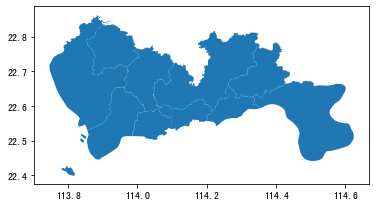

In [3]:
#读取区域信息
import geopandas as gpd
sz = gpd.read_file(r'sz.json')
sz.crs = None
sz.plot()

## 对数据进行预处理

TransBigData包也集成了数据预处理的常用方法。其中，tbd.clean_outofshape方法输入数据和研究范围区域信息，筛选剔除研究范围外的数据。而tbd.clean_taxi_status方法则可以剔除前面所提到的载客状态瞬间变化的记录。在使用预处理的方法时，需要传入相应的列，代码如下：

In [4]:
#数据预处理
#剔除研究范围外的数据
data = tbd.clean_outofshape(data, sz, col=['Lng', 'Lat'], accuracy=500)
#剔除出租车数据中载客状态瞬间变化的记录
data = tbd.clean_taxi_status(data, col=['VehicleNum', 'Time', 'OpenStatus'])
#删除信息与前后数据相同的数据以减少数据量 
data = tbd.clean_same(data, col=['VehicleNum', 'Time', 'Lng', 'Lat'])
#剔除出租车数据中速度漂移数据
data = tbd.clean_drift(data, col=['VehicleNum', 'Time', 'Lng', 'Lat'], speedlimit=60)
#超过一段时间没数据的出租车视为新车
data = tbd.id_reindex(data,'VehicleNum',timecol = 'Time',timegap = 1800)

## 栅格化

以栅格形式表达数据分布是最基本的表达方法。GPS数据经过栅格化后，每个数据点都含有对应的栅格信息，采用栅格表达数据的分布时，其表示的分布情况与真实情况接近。如果要使用TransBigData工具进行栅格首先需要确定栅格化的参数，参数可以帮助我们快速进行栅格化:


In [5]:
#栅格化
#定义范围，获取栅格化参数
bounds = [113.6,22.4,114.8,22.9]
params = tbd.grid_params(bounds,accuracy = 500)
params

(113.6, 22.4, 0.004872390756896538, 0.004496605206422906)

取得栅格化参数后，将GPS对应至栅格，由LONCOL与LATCOL两列共同指定一个栅格:

In [6]:
#将GPS栅格化
data['LONCOL'],data['LATCOL'] = tbd.GPS_to_grids(data['Lng'],data['Lat'],params)

统计每个栅格的数据量:

In [7]:
#集计栅格数据量
datatest = data.groupby(['LONCOL','LATCOL'])['VehicleNum'].count().reset_index()

生成栅格的地理图形，并将它转化为GeoDataFrame:

In [8]:
#生成栅格地理图形
datatest['geometry'] = tbd.gridid_to_polygon(datatest['LONCOL'],datatest['LATCOL'],params)
#转为GeoDataFrame
import geopandas as gpd
datatest = gpd.GeoDataFrame(datatest)


绘制栅格测试是否成功:

<AxesSubplot:>

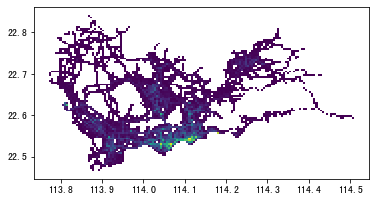

In [9]:
#绘制
datatest.plot(column = 'VehicleNum')

## 出租车出行OD提取与集计

使用tbd.taxigps_to_od方法，传入对应的列名，即可提取出行OD:

In [10]:
#从GPS数据提取OD
oddata = tbd.taxigps_to_od(data,col = ['VehicleNum','Time','Lng','Lat','OpenStatus'])
oddata

,VehicleNum,stime,slon,slat,etime,elon,elat,ID
25,22396,2021-11-06 00:19:41,114.013016,22.664818,2021-11-06 00:23:01,114.021400,22.663918,0
54,22396,2021-11-06 00:41:51,114.021767,22.640200,2021-11-06 00:43:44,114.026070,22.640266,1
57,22396,2021-11-06 00:45:44,114.028099,22.645082,2021-11-06 00:47:44,114.030380,22.650017,2
86,22396,2021-11-06 01:08:26,114.034897,22.616301,2021-11-06 01:16:34,114.035614,22.646717,3
105,22396,2021-11-06 01:26:06,114.046021,22.641251,2021-11-06 01:34:48,114.066048,22.636183,4
...,...,...,...,...,...,...,...,...
375051,36805,2021-11-06 22:37:42,114.113403,22.534767,2021-11-06 22:48:01,114.114365,22.550632,5137
375114,36805,2021-11-06 22:49:18,114.114365,22.550632,2021-11-06 22:50:40,114.115501,22.557983,5138
375126,36805,2021-11-06 22:52:07,114.115402,22.558083,2021-11-06 23:03:27,114.118484,22.547867,5139
375226,36805,2021-11-06 23:03:45,114.118484,22.547867,2021-11-06 23:20:09,114.133286,22.617750,5140


对提取出的OD进行OD的栅格集计,并生成GeoDataFrame

<AxesSubplot:>

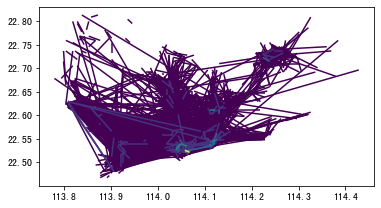

In [11]:
#栅格化OD并集计
od_gdf = tbd.odagg_grid(oddata,params)
od_gdf.plot(column = 'count')

## OD小区集计

TransBigData包也提供了将OD直接集计到小区的方法

<AxesSubplot:>

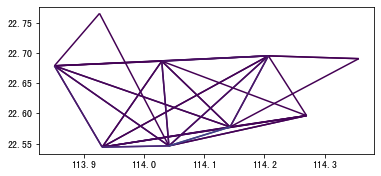

In [12]:
#OD集计到小区（在不传入栅格化参数时，直接用经纬度匹配）
od_gdf = tbd.odagg_shape(oddata,sz,round_accuracy=6)
od_gdf.plot(column = 'count')


<AxesSubplot:>

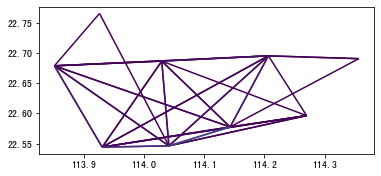

In [13]:
#OD集计到小区（传入栅格化参数时，先栅格化后匹配，可加快匹配速度，数据量大时建议使用）
od_gdf = tbd.odagg_shape(oddata,sz,params = params)
od_gdf.plot(column = 'count')

## 可视化

tbd中提供了地图底图加载和比例尺指北针的功能。使用plot_map方法添加地图底图，plotscale添加比例尺和指北针:

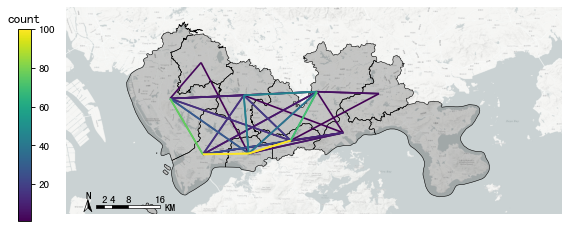

In [14]:
#创建图框
import matplotlib.pyplot as plt
import plot_map
fig =plt.figure(1,(8,8),dpi=80)
ax =plt.subplot(111)
plt.sca(ax)
#添加地图底图
tbd.plot_map(plt,bounds,zoom = 12,style = 4)
#绘制colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('count')
plt.sca(ax)
#绘制OD
od_gdf.plot(ax = ax,vmax = 100,column = 'count',cax = cax,legend = True)
#绘制小区底图
sz.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)
#添加比例尺和指北针
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

## 出租车轨迹的提取

使用tbd.taxigps_traj_point方法，输入数据和OD数据，可以提取出轨迹点

In [15]:
data_deliver,data_idle = tbd.taxigps_traj_point(data,oddata,col=['VehicleNum', 'Time', 'Lng', 'Lat', 'OpenStatus'])

In [16]:
data_deliver['OpenStatus'].value_counts()

1    166691
Name: OpenStatus, dtype: int64

对轨迹点生成载客与空载的轨迹

<AxesSubplot:>

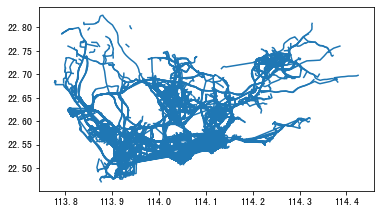

In [17]:
traj_deliver = tbd.points_to_traj(data_deliver)
traj_deliver.plot()

In [18]:
traj_deliver.to_file(r'traj.json',driver = 'GeoJSON')

In [19]:
len(traj_deliver)

5142

<AxesSubplot:>

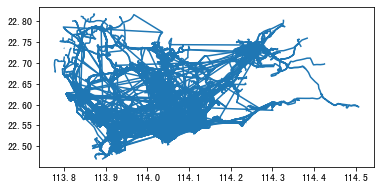

In [26]:
traj_idle = tbd.points_to_traj(data_idle[data_idle['OpenStatus'] == 0])
traj_idle.plot()

In [27]:
len(traj_idle)

5142